In [18]:
# ============================================
# 체스보드 기하 지표 계산 Colab용 코드
# ============================================
import math
from typing import List, Tuple
import yaml

# 타입 alias
Point = Tuple[float, float]


# ============================================
# 0. 유틸: Convex Hull & Polygon Area
# ============================================
def cross(o: Point, a: Point, b: Point) -> float:
    """2D 벡터 외적 (OA x OB). o,a,b는 (x,y)."""
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])


def convex_hull(points: List[Point]) -> List[Point]:
    """
    Monotone chain 알고리즘으로 convex hull 반환 (반시계 방향).
    입력: (x,y) 리스트
    출력: hull 꼭짓점 리스트
    """
    pts = sorted(set(points))
    if len(pts) <= 1:
        return pts

    lower = []
    for p in pts:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)

    upper = []
    for p in reversed(pts):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    # 마지막 점은 중복이므로 제거
    return lower[:-1] + upper[:-1]


def polygon_area(poly: List[Point]) -> float:
    """Shoelace 공식으로 다각형 면적 계산 (poly는 순환 순서로 주어졌다고 가정)."""
    if len(poly) < 3:
        return 0.0
    s = 0.0
    n = len(poly)
    for i in range(n):
        x1, y1 = poly[i]
        x2, y2 = poly[(i + 1) % n]
        s += x1 * y2 - x2 * y1
    return abs(s) * 0.5


# ============================================
# 1. Polygon vs Rectangle 클리핑 (Sutherland–Hodgman)
# ============================================
def clip_polygon_with_halfplane(poly: List[Point], inside_fn):
    """
    Sutherland–Hodgman의 한 단계: poly를 하나의 half-plane으로 클리핑.
    inside_fn(p) 가 True면 반평면 내부라고 가정.
    """
    if not poly:
        return []

    output = []
    prev = poly[-1]
    prev_inside = inside_fn(prev)

    for curr in poly:
        curr_inside = inside_fn(curr)
        if prev_inside and curr_inside:
            # 둘 다 inside → curr 추가
            output.append(curr)
        elif prev_inside and not curr_inside:
            # prev in, curr out → 경계점만 추가
            inter = intersect_with_boundary(prev, curr, inside_fn)
            if inter is not None:
                output.append(inter)
        elif (not prev_inside) and curr_inside:
            # prev out, curr in → 경계점 + curr
            inter = intersect_with_boundary(prev, curr, inside_fn)
            if inter is not None:
                output.append(inter)
            output.append(curr)
        # 둘 다 outside면 아무것도 안 넣음
        prev = curr
        prev_inside = curr_inside
    return output


def intersect_with_boundary(p1: Point, p2: Point, inside_fn):
    """
    직선 p1->p2와 half-plane 경계의 교점 계산.
    여기서는 axis-aligned rectangle의 한 면과 교차한다고 가정하고,
    inside_fn 이 변하는 지점을 간단한 이분법으로 근사(실무엔 충분).
    """
    # (이분 탐색으로 내부/외부 경계 근사) - 정확도가 엄청 필요하진 않으므로 간단 버전
    t_low, t_high = 0.0, 1.0
    for _ in range(20):  # 2^-20 ~ 1e-6 정도
        t_mid = 0.5 * (t_low + t_high)
        mid = (p1[0] + (p2[0] - p1[0]) * t_mid,
               p1[1] + (p2[1] - p1[1]) * t_mid)
        if inside_fn(mid) == inside_fn(p1):
            t_low = t_mid
        else:
            t_high = t_mid
    t = 0.5 * (t_low + t_high)
    return (p1[0] + (p2[0] - p1[0]) * t,
            p1[1] + (p2[1] - p1[1]) * t)


def clip_polygon_with_rect(poly: List[Point], x_min, y_min, x_max, y_max) -> List[Point]:
    """
    다각형 poly 와 axis-aligned rectangle [x_min, x_max] × [y_min, y_max] 의 교집합 다각형 계산.
    poly는 CCW 순서라고 가정.
    """
    if not poly:
        return []

    # 4개의 half-plane으로 순차 클리핑
    # x >= x_min
    poly = clip_polygon_with_halfplane(
        poly,
        inside_fn=lambda p: p[0] >= x_min
    )
    if not poly:
        return []
    # x <= x_max
    poly = clip_polygon_with_halfplane(
        poly,
        inside_fn=lambda p: p[0] <= x_max
    )
    if not poly:
        return []
    # y >= y_min
    poly = clip_polygon_with_halfplane(
        poly,
        inside_fn=lambda p: p[1] >= y_min
    )
    if not poly:
        return []
    # y <= y_max
    poly = clip_polygon_with_halfplane(
        poly,
        inside_fn=lambda p: p[1] <= y_max
    )
    return poly


# ============================================
# 2. Grid Coverage
# ============================================
def compute_grid_coverage(corners2d: List[Point],
                          resolution: Tuple[int, int],
                          grid: int = 3):
    """
    corners2d 의 convex hull 과, image 를 grid x grid 로 나눈 셀들의
    overlap 비율을 계산.
    반환:
      coverage_per_cell: 길이 grid*grid, 각 셀별 coverage 비율 (0~1)
      best_cell_index: coverage 최댓값인 셀 인덱스 (0 ~ grid*grid-1)
      best_ratio: 해당 coverage 값
    """
    W, H = resolution
    if not corners2d:
        return [0.0] * (grid * grid), -1, 0.0

    hull = convex_hull(corners2d)
    hull_area = polygon_area(hull)
    if hull_area <= 0.0:
        return [0.0] * (grid * grid), -1, 0.0

    cell_w = W / grid
    cell_h = H / grid

    coverage_per_cell = []
    best_idx = -1
    best_ratio = 0.0

    for gy in range(grid):
        for gx in range(grid):
            x_min = gx * cell_w
            x_max = (gx + 1) * cell_w
            y_min = gy * cell_h
            y_max = (gy + 1) * cell_h

            clipped = clip_polygon_with_rect(hull, x_min, y_min, x_max, y_max)
            inter_area = polygon_area(clipped)
            cell_area = cell_w * cell_h
            ratio = inter_area / cell_area if cell_area > 0 else 0.0
            coverage_per_cell.append(ratio)

    for idx, v in enumerate(coverage_per_cell):
        if v > best_ratio:
            best_ratio = v
            best_idx = idx

    return coverage_per_cell, best_idx, best_ratio


# ============================================
# 3. Corner Count
# ============================================
def compute_corner_count(corners2d: List[Point]) -> int:
    return len(corners2d)


# ============================================
# 4. Global Coverage Ratio
# ============================================
def compute_global_coverage(corners2d: List[Point],
                            resolution: Tuple[int, int]) -> float:
    W, H = resolution
    if not corners2d:
        return 0.0
    hull = convex_hull(corners2d)
    hull_area = polygon_area(hull)
    img_area = float(W) * float(H)
    if img_area <= 0.0:
        return 0.0
    return hull_area / img_area


# ============================================
# 5. Spacing Ratios (Tilt / Pan)
# ============================================
def compute_spacing_ratios(corners2d: List[Point],
                           rows: int, cols: int):
    """
    corners2d: row-major, 길이 = rows * cols
    반환:
      tilt_raw: min(topRowGap, bottomRowGap) / max(...)
      pan_raw : min(leftColGap, rightColGap) / max(...)
    """
    import numpy as np
    pts = np.array(corners2d, dtype=np.float64)
    assert pts.shape[0] == rows * cols

    def avg_row_gap(r):
        # r와 r+1 사이 세로 간격 평균
        p = pts[r * cols:(r + 1) * cols, :]
        q = pts[(r + 1) * cols:(r + 2) * cols, :]
        d = np.linalg.norm(q - p, axis=1)
        return float(d.mean())

    def avg_col_gap(c):
        # c와 c+1 사이 가로 간격 평균
        p = pts[:, :]
        p = p.reshape(rows, cols, 2)
        d = np.linalg.norm(p[:, c + 1, :] - p[:, c, :], axis=1)
        return float(d.mean())

    tilt_raw = 1.0
    pan_raw = 1.0

    if rows >= 2:
        top = avg_row_gap(0)
        bottom = avg_row_gap(rows - 2)
        if top > 0.0 and bottom > 0.0:
            tilt_raw = min(top, bottom) / max(top, bottom)

    if cols >= 2:
        left = avg_col_gap(0)
        right = avg_col_gap(cols - 2)
        if left > 0.0 and right > 0.0:
            pan_raw = min(left, right) / max(left, right)

    return tilt_raw, pan_raw


# ============================================
# 6. Roll Angle (deg)
# ============================================
def compute_roll_deg(corners2d: List[Point],
                     rows: int, cols: int) -> float:
    """
    가로 격자선 벡터들의 각도를 평균해서 roll angle(deg) 추정.
    필요하면 circular mean으로 바꿔도 됨 (지금은 단순 평균).
    """
    import numpy as np
    pts = np.array(corners2d, dtype=np.float64)
    assert pts.shape[0] == rows * cols
    pts = pts.reshape(rows, cols, 2)

    angles = []
    for r in range(rows):
        for c in range(cols - 1):
            p = pts[r, c]
            q = pts[r, c + 1]
            dx = q[0] - p[0]
            dy = q[1] - p[1]
            theta = math.atan2(dy, dx)  # rad
            angles.append(theta)

    if not angles:
        return 0.0

    mean_theta = sum(angles) / len(angles)
    return math.degrees(mean_theta)


# ============================================
# 7. YAML 로더 (사용자 제공 형식 전제)
# ============================================
def load_corners2d_from_yaml(path: str) -> List[Point]:
    """
    사용자가 예시로 준 형식:
    ---
    - corners2d: [[x,y], [x,y], ...]
    - corners3d: [[X,Y,Z], ...]
    ---
    최상단이 list이고 그 중 dict에 'corners2d' key가 있는 구조라고 가정.
    """
    with open(path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f)

    if not isinstance(data, list):
        raise TypeError("YAML top-level must be a list")

    corners2d = None
    for item in data:
        if isinstance(item, dict) and "corners2d" in item:
            raw = item["corners2d"]
            corners2d = [(float(x), float(y)) for (x, y) in raw]
            break

    if corners2d is None:
        raise KeyError("'corners2d' not found in YAML")

    return corners2d


# ============================================
# 8. 사용 예시 (Colab에서 경로만 바꿔서 테스트)
# ============================================
if __name__ == "__main__":
    # 예시: Colab에 업로드한 yaml 경로로 바꿔서 테스트
    yaml_path = "corners_nx_mono_01.yaml"  # <- 여기에 본인 파일 이름
    try:
        corners = load_corners2d_from_yaml(yaml_path)
    except Exception as e:
        print("YAML load error:", e)
        corners = []

    # 예시 해상도 (실제 이미지 해상도 넣으면 됨)
    resolution = (1920, 1080)
    rows, cols = 5, 8  # 예: 5x8 내부 코너

    if corners:
        # 1) Grid Coverage
        cov_cells, best_idx, best_ratio = compute_grid_coverage(corners, resolution, grid=3)
        print("Grid coverage per cell:", cov_cells)
        print("Best cell index / ratio:", best_idx, best_ratio)

        # 2) Corner count
        cnt = compute_corner_count(corners)
        print("Corner count:", cnt)

        # 3) Global Coverage
        g_cov = compute_global_coverage(corners, resolution)
        print("Global coverage:", g_cov)

        # 4) Spacing ratios
        tilt_raw, pan_raw = compute_spacing_ratios(corners, rows, cols)
        print("Tilt raw ratio:", tilt_raw)
        print("Pan raw ratio:", pan_raw)

        # 5) Roll angle
        roll_deg = compute_roll_deg(corners, rows, cols)
        print("Roll (deg):", roll_deg)
    else:
        print("No corners loaded. Set correct yaml_path and rerun.")


YAML load error: [Errno 2] No such file or directory: 'corners_nx_mono_01.yaml'
No corners loaded. Set correct yaml_path and rerun.


In [19]:
# ============================================
# 체스보드 기하 지표 계산 Colab용 코드
# ============================================
import math
from typing import List, Tuple
import yaml

# 타입 alias
Point = Tuple[float, float]


# ============================================
# 0. 유틸: Convex Hull & Polygon Area
# ============================================
def cross(o: Point, a: Point, b: Point) -> float:
    """2D 벡터 외적 (OA x OB). o,a,b는 (x,y)."""
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])


def convex_hull(points: List[Point]) -> List[Point]:
    """
    Monotone chain 알고리즘으로 convex hull 반환 (반시계 방향).
    입력: (x,y) 리스트
    출력: hull 꼭짓점 리스트
    """
    pts = sorted(set(points))
    if len(pts) <= 1:
        return pts

    lower = []
    for p in pts:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)

    upper = []
    for p in reversed(pts):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    # 마지막 점은 중복이므로 제거
    return lower[:-1] + upper[:-1]


def polygon_area(poly: List[Point]) -> float:
    """Shoelace 공식으로 다각형 면적 계산 (poly는 순환 순서로 주어졌다고 가정)."""
    if len(poly) < 3:
        return 0.0
    s = 0.0
    n = len(poly)
    for i in range(n):
        x1, y1 = poly[i]
        x2, y2 = poly[(i + 1) % n]
        s += x1 * y2 - x2 * y1
    return abs(s) * 0.5


# ============================================
# 1. Polygon vs Rectangle 클리핑 (Sutherland–Hodgman)
# ============================================
def clip_polygon_with_halfplane(poly: List[Point], inside_fn):
    """
    Sutherland–Hodgman의 한 단계: poly를 하나의 half-plane으로 클리핑.
    inside_fn(p) 가 True면 반평면 내부라고 가정.
    """
    if not poly:
        return []

    output = []
    prev = poly[-1]
    prev_inside = inside_fn(prev)

    for curr in poly:
        curr_inside = inside_fn(curr)
        if prev_inside and curr_inside:
            # 둘 다 inside → curr 추가
            output.append(curr)
        elif prev_inside and not curr_inside:
            # prev in, curr out → 경계점만 추가
            inter = intersect_with_boundary(prev, curr, inside_fn)
            if inter is not None:
                output.append(inter)
        elif (not prev_inside) and curr_inside:
            # prev out, curr in → 경계점 + curr
            inter = intersect_with_boundary(prev, curr, inside_fn)
            if inter is not None:
                output.append(inter)
            output.append(curr)
        # 둘 다 outside면 아무것도 안 넣음
        prev = curr
        prev_inside = curr_inside
    return output


def intersect_with_boundary(p1: Point, p2: Point, inside_fn):
    """
    직선 p1->p2와 half-plane 경계의 교점 계산.
    여기서는 axis-aligned rectangle의 한 면과 교차한다고 가정하고,
    inside_fn 이 변하는 지점을 간단한 이분법으로 근사(실무엔 충분).
    """
    # (이분 탐색으로 내부/외부 경계 근사) - 정확도가 엄청 필요하진 않으므로 간단 버전
    t_low, t_high = 0.0, 1.0
    for _ in range(20):  # 2^-20 ~ 1e-6 정도
        t_mid = 0.5 * (t_low + t_high)
        mid = (p1[0] + (p2[0] - p1[0]) * t_mid,
               p1[1] + (p2[1] - p1[1]) * t_mid)
        if inside_fn(mid) == inside_fn(p1):
            t_low = t_mid
        else:
            t_high = t_mid
    t = 0.5 * (t_low + t_high)
    return (p1[0] + (p2[0] - p1[0]) * t,
            p1[1] + (p2[1] - p1[1]) * t)


def clip_polygon_with_rect(poly: List[Point], x_min, y_min, x_max, y_max) -> List[Point]:
    """
    다각형 poly 와 axis-aligned rectangle [x_min, x_max] × [y_min, y_max] 의 교집합 다각형 계산.
    poly는 CCW 순서라고 가정.
    """
    if not poly:
        return []

    # 4개의 half-plane으로 순차 클리핑
    # x >= x_min
    poly = clip_polygon_with_halfplane(
        poly,
        inside_fn=lambda p: p[0] >= x_min
    )
    if not poly:
        return []
    # x <= x_max
    poly = clip_polygon_with_halfplane(
        poly,
        inside_fn=lambda p: p[0] <= x_max
    )
    if not poly:
        return []
    # y >= y_min
    poly = clip_polygon_with_halfplane(
        poly,
        inside_fn=lambda p: p[1] >= y_min
    )
    if not poly:
        return []
    # y <= y_max
    poly = clip_polygon_with_halfplane(
        poly,
        inside_fn=lambda p: p[1] <= y_max
    )
    return poly


# ============================================
# 2. Grid Coverage
# ============================================
def compute_grid_coverage(corners2d: List[Point],
                          resolution: Tuple[int, int],
                          grid: int = 3):
    """
    corners2d 의 convex hull 과, image 를 grid x grid 로 나눈 셀들의
    overlap 비율을 계산.
    반환:
      coverage_per_cell: 길이 grid*grid, 각 셀별 coverage 비율 (0~1)
      best_cell_index: coverage 최댓값인 셀 인덱스 (0 ~ grid*grid-1)
      best_ratio: 해당 coverage 값
    """
    W, H = resolution
    if not corners2d:
        return [0.0] * (grid * grid), -1, 0.0

    hull = convex_hull(corners2d)
    hull_area = polygon_area(hull)
    if hull_area <= 0.0:
        return [0.0] * (grid * grid), -1, 0.0

    cell_w = W / grid
    cell_h = H / grid

    coverage_per_cell = []
    best_idx = -1
    best_ratio = 0.0

    for gy in range(grid):
        for gx in range(grid):
            x_min = gx * cell_w
            x_max = (gx + 1) * cell_w
            y_min = gy * cell_h
            y_max = (gy + 1) * cell_h

            clipped = clip_polygon_with_rect(hull, x_min, y_min, x_max, y_max)
            inter_area = polygon_area(clipped)
            cell_area = cell_w * cell_h
            ratio = inter_area / cell_area if cell_area > 0 else 0.0
            coverage_per_cell.append(ratio)

    for idx, v in enumerate(coverage_per_cell):
        if v > best_ratio:
            best_ratio = v
            best_idx = idx

    return coverage_per_cell, best_idx, best_ratio


# ============================================
# 3. Corner Count
# ============================================
def compute_corner_count(corners2d: List[Point]) -> int:
    return len(corners2d)


# ============================================
# 4. Global Coverage Ratio
# ============================================
def compute_global_coverage(corners2d: List[Point],
                            resolution: Tuple[int, int]) -> float:
    W, H = resolution
    if not corners2d:
        return 0.0
    hull = convex_hull(corners2d)
    hull_area = polygon_area(hull)
    img_area = float(W) * float(H)
    if img_area <= 0.0:
        return 0.0
    return hull_area / img_area


# ============================================
# 5. Spacing Ratios (Tilt / Pan)
# ============================================
def compute_spacing_ratios(corners2d: List[Point],
                           rows: int, cols: int):
    """
    corners2d: row-major, 길이 = rows * cols
    반환:
      tilt_raw: min(topRowGap, bottomRowGap) / max(...)
      pan_raw : min(leftColGap, rightColGap) / max(...)
    """
    import numpy as np
    pts = np.array(corners2d, dtype=np.float64)
    assert pts.shape[0] == rows * cols

    def avg_row_gap(r):
        # r와 r+1 사이 세로 간격 평균
        p = pts[r * cols:(r + 1) * cols, :]
        q = pts[(r + 1) * cols:(r + 2) * cols, :]
        d = np.linalg.norm(q - p, axis=1)
        return float(d.mean())

    def avg_col_gap(c):
        # c와 c+1 사이 가로 간격 평균
        p = pts[:, :]
        p = p.reshape(rows, cols, 2)
        d = np.linalg.norm(p[:, c + 1, :] - p[:, c, :], axis=1)
        return float(d.mean())

    tilt_raw = 1.0
    pan_raw = 1.0

    if rows >= 2:
        top = avg_row_gap(0)
        bottom = avg_row_gap(rows - 2)
        if top > 0.0 and bottom > 0.0:
            tilt_raw = min(top, bottom) / max(top, bottom)

    if cols >= 2:
        left = avg_col_gap(0)
        right = avg_col_gap(cols - 2)
        if left > 0.0 and right > 0.0:
            pan_raw = min(left, right) / max(left, right)

    return tilt_raw, pan_raw


# ============================================
# 6. Roll Angle (deg)
# ============================================
def compute_roll_deg(corners2d: List[Point],
                     rows: int, cols: int) -> float:
    """
    가로 격자선 벡터들의 각도를 평균해서 roll angle(deg) 추정.
    필요하면 circular mean으로 바꿔도 됨 (지금은 단순 평균).
    """
    import numpy as np
    pts = np.array(corners2d, dtype=np.float64)
    assert pts.shape[0] == rows * cols
    pts = pts.reshape(rows, cols, 2)

    angles = []
    for r in range(rows):
        for c in range(cols - 1):
            p = pts[r, c]
            q = pts[r, c + 1]
            dx = q[0] - p[0]
            dy = q[1] - p[1]
            theta = math.atan2(dy, dx)  # rad
            angles.append(theta)

    if not angles:
        return 0.0

    mean_theta = sum(angles) / len(angles)
    return math.degrees(mean_theta)


# ============================================
# 7. YAML 로더 (사용자 제공 형식 전제)
# ============================================
def load_corners2d_from_yaml(path: str) -> List[Point]:
    """
    사용자가 예시로 준 형식:
    ---
    - corners2d: [[x,y], [x,y], ...]
    - corners3d: [[X,Y,Z], ...]
    ---
    최상단이 list이고 그 중 dict에 'corners2d' key가 있는 구조라고 가정.
    """
    with open(path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f)

    if not isinstance(data, list):
        raise TypeError("YAML top-level must be a list")

    corners2d = None
    for item in data:
        if isinstance(item, dict) and "corners2d" in item:
            raw = item["corners2d"]
            corners2d = [(float(x), float(y)) for (x, y) in raw]
            break

    if corners2d is None:
        raise KeyError("'corners2d' not found in YAML")

    return corners2d


# ============================================
# 8. 사용 예시 (Colab에서 경로만 바꿔서 테스트)
# ============================================
if __name__ == "__main__":
    # 예시: Colab에 업로드한 yaml 경로로 바꿔서 테스트
    yaml_path = "corners_nx_mono_01.yaml"  # <- 여기에 본인 파일 이름
    try:
        corners = load_corners2d_from_yaml(yaml_path)
    except Exception as e:
        print("YAML load error:", e)
        corners = []

    # 예시 해상도 (실제 이미지 해상도 넣으면 됨)
    resolution = (1920, 1080)
    rows, cols = 5, 8  # 예: 5x8 내부 코너

    if corners:
        # 1) Grid Coverage
        cov_cells, best_idx, best_ratio = compute_grid_coverage(corners, resolution, grid=3)
        print("Grid coverage per cell:", cov_cells)
        print("Best cell index / ratio:", best_idx, best_ratio)

        # 2) Corner count
        cnt = compute_corner_count(corners)
        print("Corner count:", cnt)

        # 3) Global Coverage
        g_cov = compute_global_coverage(corners, resolution)
        print("Global coverage:", g_cov)

        # 4) Spacing ratios
        tilt_raw, pan_raw = compute_spacing_ratios(corners, rows, cols)
        print("Tilt raw ratio:", tilt_raw)
        print("Pan raw ratio:", pan_raw)

        # 5) Roll angle
        roll_deg = compute_roll_deg(corners, rows, cols)
        print("Roll (deg):", roll_deg)
    else:
        print("No corners loaded. Set correct yaml_path and rerun.")



# ============================================
# 9. Corners Mean Position (u, v)
# ============================================

def compute_mean_uv(corners2d, resolution):
    """
    corners2d: [(u, v), ...]
    resolution: (W, H)
    반환: mean_u, mean_v, mean_u_norm, mean_v_norm
    """

    if not corners2d:
        return 0.0, 0.0, 0.0, 0.0

    W, H = resolution
    u_sum = 0.0
    v_sum = 0.0
    
    for (u, v) in corners2d:
        u_sum += u
        v_sum += v
        
    mean_u = u_sum / len(corners2d)
    mean_v = v_sum / len(corners2d)

    return mean_u, mean_v, mean_u / W, mean_v / H


YAML load error: [Errno 2] No such file or directory: 'corners_nx_mono_01.yaml'
No corners loaded. Set correct yaml_path and rerun.


In [20]:
# ==================================

# Main Script

# ==================================

import os
import glob
import re

width, height = 640, 480

image_dir = '/home/minkyung/.opticalib/data/251111-DY-batch-custom1/tv'
yaml_dir = image_dir + '/result'

cam_name = 'tv_side'

if cam_name == 'tv_side' :
    image_pattern = re.compile(r"tv_side_(\d+)\.bmp$")
    yaml_pattern = re.compile(r"corners_tv_side_(\d+)\.yaml")
elif cam_name == 'tv_top' :
    image_pattern = re.compile(r"tv_top_(\d+)\.bmp$")
    yaml_pattern = re.compile(r"corners_tv_top_(\d+)\.yaml")
    
    

# Extact file
image_files = [ os.path.basename(f) for f in glob.glob(os.path.join(image_dir, "*.bmp")) if image_pattern.search(f) ]
yaml_files = [ os.path.basename(f) for f in glob.glob(os.path.join(yaml_dir, "*.yaml")) if yaml_pattern.search(f) ]

image_names = sorted(image_files)
yaml_names = sorted(yaml_files)

print("Image files", len(image_names), 'found')
print("Yaml files", len(yaml_names), 'found')


def get_postfix(name: str) -> str | None:
    m = re.search(r"(\d+)(?=\.[^.]+$)", name)
    return m.group(1) if m else None


image_dict = { get_postfix(im_name): im_name for im_name in image_names }
print(image_dict)


#
# corners_ yaml 이 존재하는 이미지파일들만 모으기 
#

valid_images = []
valid_yamls = []

for yaml_name in yaml_names:
    yaml_postfix = get_postfix(yaml_name)
    image_name = image_dict.get(yaml_postfix)
    
    if image_name is None:
        print(f"Warning: 해당 yaml에 대응하는 이미지 파일이 없습니다: {yaml_name}")
        continue

    image_path = os.path.join(image_dir, image_name)
    yaml_path = os.path.join(image_dir, 'result', yaml_name)

    valid_images.append(image_path)
    valid_yamls.append(yaml_path)


print('Print Valid files')
for (i_path, y_path) in zip(valid_images, valid_yamls):
    print('image', i_path, '  yaml', y_path)


Image files 20 found
Yaml files 14 found
{'01': 'tv_side_01.bmp', '02': 'tv_side_02.bmp', '03': 'tv_side_03.bmp', '04': 'tv_side_04.bmp', '05': 'tv_side_05.bmp', '06': 'tv_side_06.bmp', '07': 'tv_side_07.bmp', '08': 'tv_side_08.bmp', '09': 'tv_side_09.bmp', '10': 'tv_side_10.bmp', '11': 'tv_side_11.bmp', '12': 'tv_side_12.bmp', '13': 'tv_side_13.bmp', '14': 'tv_side_14.bmp', '15': 'tv_side_15.bmp', '16': 'tv_side_16.bmp', '17': 'tv_side_17.bmp', '18': 'tv_side_18.bmp', '19': 'tv_side_19.bmp', '21': 'tv_side_21.bmp'}
Print Valid files
image /home/minkyung/.opticalib/data/251111-DY-batch-custom1/tv/tv_side_01.bmp   yaml /home/minkyung/.opticalib/data/251111-DY-batch-custom1/tv/result/corners_tv_side_01.yaml
image /home/minkyung/.opticalib/data/251111-DY-batch-custom1/tv/tv_side_02.bmp   yaml /home/minkyung/.opticalib/data/251111-DY-batch-custom1/tv/result/corners_tv_side_02.yaml
image /home/minkyung/.opticalib/data/251111-DY-batch-custom1/tv/tv_side_03.bmp   yaml /home/minkyung/.opticali

img:  tv_side_01.bmp
best_grid 4
best_grid_cov 0.29042646362081637
coverage_per_grid [0.0, 0.0, 0.0, 0.010272156664947296, 0.29042646362081637, 0.0, 0.0, 0.0, 0.0]
mean position U 0.47260890901088715
mean position V 0.48059587001800536
global coverage 0.03341095780952931
Tilt raw ratio: 0.7078407771427013
Pan raw ratio: 0.9181970002218829
Roll (deg): 0.234254048769921


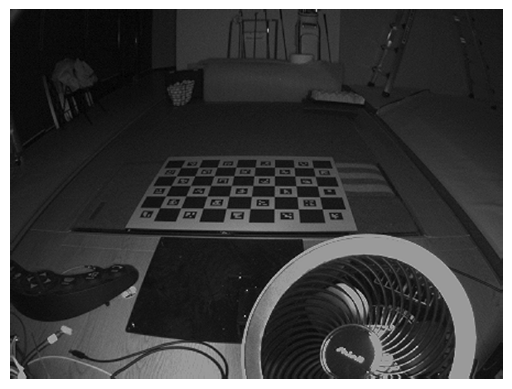

img:  tv_side_02.bmp
best_grid 4
best_grid_cov 0.27157289975638604
coverage_per_grid [0.0, 0.0, 0.0, 0.022019993875055658, 0.27157289975638604, 0.0, 0.0, 0.0, 0.0]
mean position U 0.4581742829084396
mean position V 0.4778509855270386
global coverage 0.03262143262571575
Tilt raw ratio: 0.7303478469148746
Pan raw ratio: 0.8907709478766518
Roll (deg): -9.363814816696692


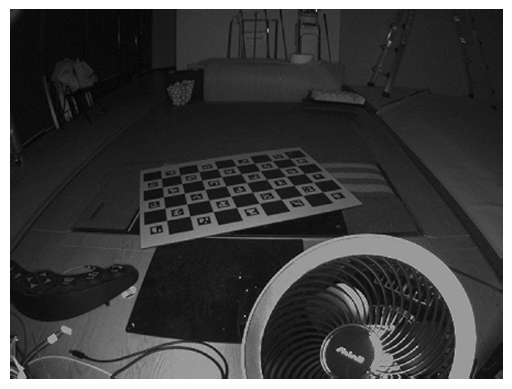

img:  tv_side_03.bmp
best_grid 4
best_grid_cov 0.30065787416080897
coverage_per_grid [0.0, 0.0, 0.0, 0.011578869523979981, 0.30065787416080897, 0.0, 0.0, 0.0, 0.0]
mean position U 0.4661722612380982
mean position V 0.4839393695195516
global coverage 0.03469297152053211
Tilt raw ratio: 0.7393751178785404
Pan raw ratio: 0.7473170249773933
Roll (deg): 8.961675168409098


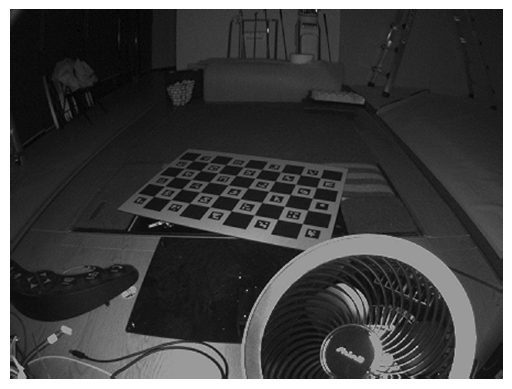

img:  tv_side_04.bmp
best_grid 4
best_grid_cov 0.2743078941637999
coverage_per_grid [0.0, 0.002076282993828755, 0.0, 0.007037601757820404, 0.2743078941637999, 0.0, 0.0, 0.0, 0.0]
mean position U 0.4807148855924607
mean position V 0.4130729738871256
global coverage 0.03149130876838323
Tilt raw ratio: 0.709238904508053
Pan raw ratio: 0.9834623120069019
Roll (deg): 14.316790665879942


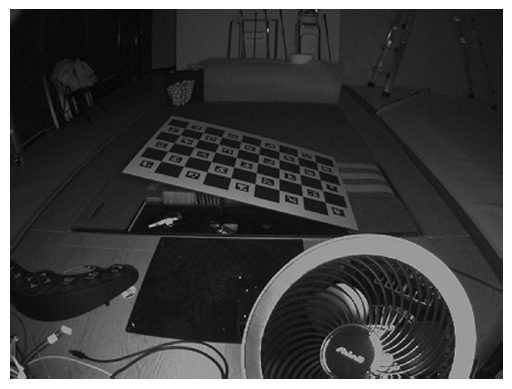

img:  tv_side_08.bmp
best_grid 4
best_grid_cov 0.5015244913966493
coverage_per_grid [0.0016234859930160715, 0.06397610853977279, 0.0, 0.04136462533502701, 0.5015244913966493, 0.0, 0.0, 0.0, 0.0]
mean position U 0.4680109167098999
mean position V 0.410730345249176
global coverage 0.06760985680716279
Tilt raw ratio: 0.8001330237360678
Pan raw ratio: 0.9007838153497482
Roll (deg): -0.25680519844774496


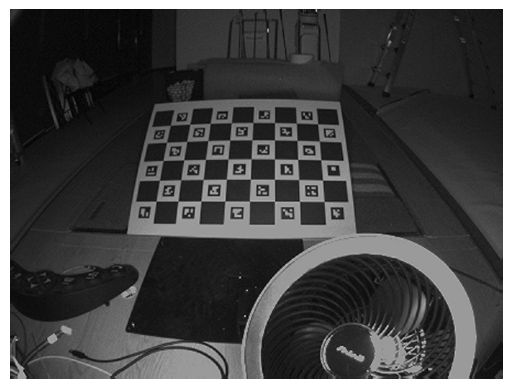

img:  tv_side_11.bmp
best_grid 5
best_grid_cov 0.23918856744941938
coverage_per_grid [0.0, 0.0, 0.0, 0.0, 0.13815804605511336, 0.23918856744941938, 0.0, 0.0, 0.0]
mean position U 0.7176631188392639
mean position V 0.5405046431223551
global coverage 0.04192740150050364
Tilt raw ratio: 0.7452423970072325
Pan raw ratio: 0.767196423103896
Roll (deg): 0.9146797092053256


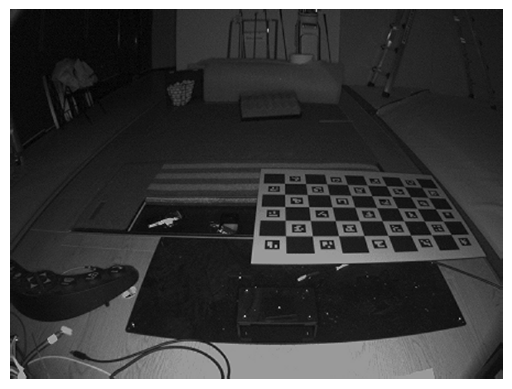

img:  tv_side_12.bmp
best_grid 3
best_grid_cov 0.26377037863784325
coverage_per_grid [0.0, 0.0, 0.0, 0.26377037863784325, 0.0346904920236345, 0.0, 0.0, 0.0, 0.0]
mean position U 0.2256191274523735
mean position V 0.5443533500035603
global coverage 0.03316231896238643
Tilt raw ratio: 0.7781473635044934
Pan raw ratio: 0.6373233375983897
Roll (deg): 0.3395319838487472


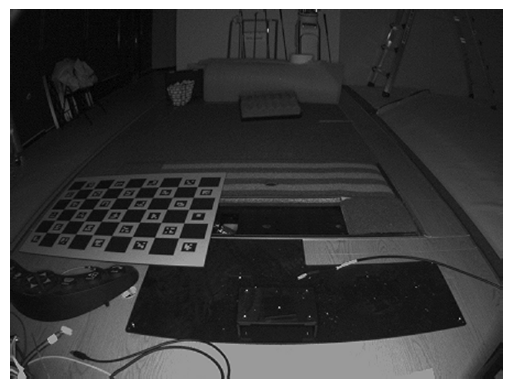

img:  tv_side_14.bmp
best_grid 1
best_grid_cov 0.31702566567784357
coverage_per_grid [0.0, 0.31702566567784357, 0.0, 0.0, 0.06188904690571231, 0.0, 0.0, 0.0, 0.0]
mean position U 0.48298923850059505
mean position V 0.2726907495657603
global coverage 0.0421016347315062
Tilt raw ratio: 0.8402793141173154
Pan raw ratio: 0.932942422314127
Roll (deg): -0.8191314262939339


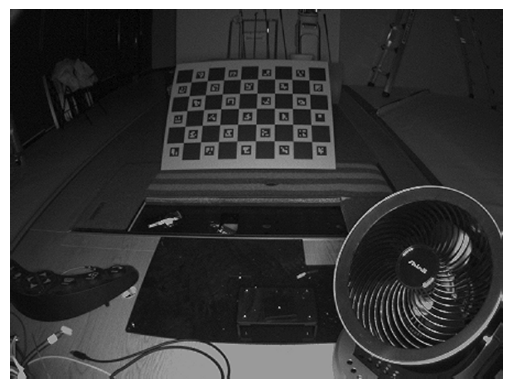

img:  tv_side_15.bmp
best_grid 2
best_grid_cov 0.15944620508231327
coverage_per_grid [0.0, 0.12065721262047414, 0.15944620508231327, 0.0, 0.0399949004879549, 0.08925159050208485, 0.0, 0.0, 0.0]
mean position U 0.6941395366191865
mean position V 0.29662975390752155
global coverage 0.04548332318809192
Tilt raw ratio: 0.8453145019485595
Pan raw ratio: 0.9842072631273703
Roll (deg): 7.565601237133647


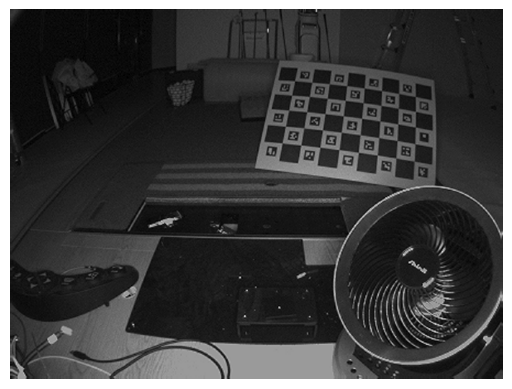

img:  tv_side_16.bmp
best_grid 0
best_grid_cov 0.13024179944432557
coverage_per_grid [0.13024179944432557, 0.12776091982749282, 0.0, 0.0907799330143079, 0.0442239566536249, 0.0, 0.0, 0.0, 0.0]
mean position U 0.31757278621196744
mean position V 0.3019863780339559
global coverage 0.043667400993305704
Tilt raw ratio: 0.840584614138298
Pan raw ratio: 0.9590163227555626
Roll (deg): -10.685636675522424


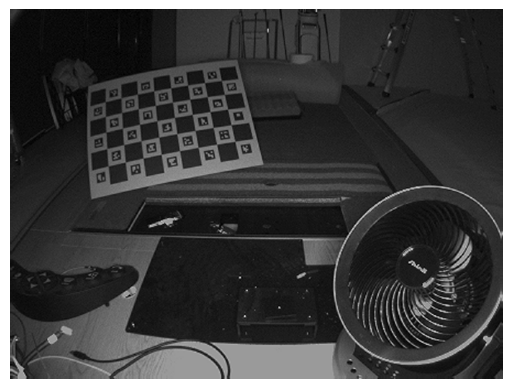

img:  tv_side_17.bmp
best_grid 5
best_grid_cov 0.5276398939895228
coverage_per_grid [0.0, 0.03957966168197636, 0.0952295371083085, 0.0, 0.12455607926945222, 0.5276398939895228, 0.0, 0.0, 0.0]
mean position U 0.7657998180389404
mean position V 0.4131251001358032
global coverage 0.08744501911658441
Tilt raw ratio: 0.8630464881002414
Pan raw ratio: 0.9183042196733593
Roll (deg): 10.96891670116709


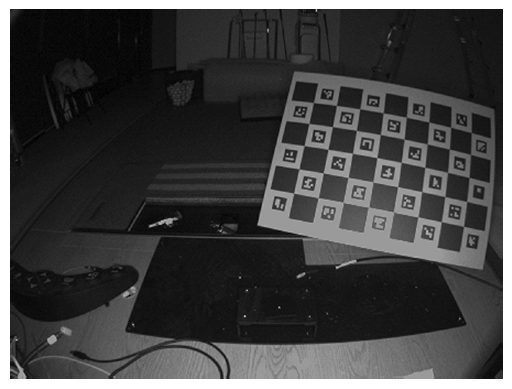

img:  tv_side_18.bmp
best_grid 3
best_grid_cov 0.527843941310073
coverage_per_grid [0.05274929902104457, 0.037107649293659485, 0.0, 0.527843941310073, 0.1638503202015394, 0.0, 0.0, 0.0, 0.0]
mean position U 0.24454529374837874
mean position V 0.4328825465838114
global coverage 0.08683902331403516
Tilt raw ratio: 0.859703945314562
Pan raw ratio: 0.748038766280394
Roll (deg): -8.518572571684496


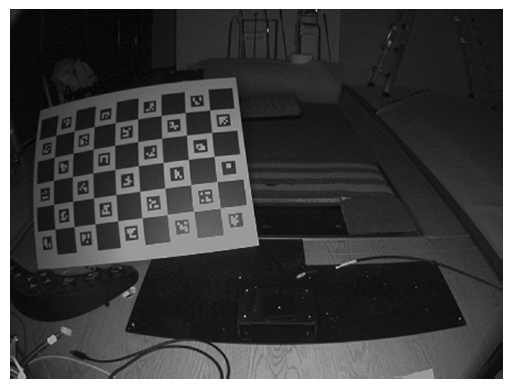

img:  tv_side_19.bmp
best_grid 4
best_grid_cov 0.30979763482346356
coverage_per_grid [0.0, 0.0049247038177058396, 0.0, 0.07200346033460808, 0.30979763482346356, 0.0, 0.0, 0.0, 0.0]
mean position U 0.4375301337242126
mean position V 0.3873893737792969
global coverage 0.04296953321953083
Tilt raw ratio: 0.6642859142242977
Pan raw ratio: 0.8190394715491133
Roll (deg): -0.40950824442551437


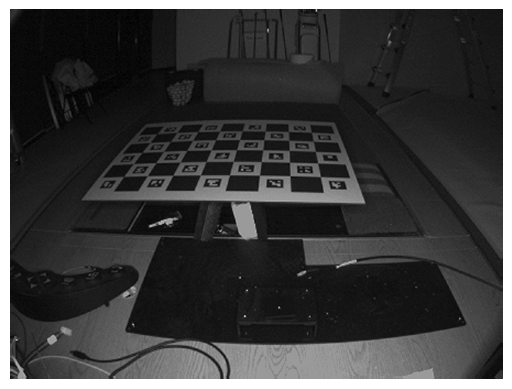

img:  tv_side_21.bmp
best_grid 4
best_grid_cov 0.6203419398398018
coverage_per_grid [0.0, 0.02539594692568471, 0.003513220588120802, 0.0, 0.6203419398398018, 0.363866540212011, 0.0, 0.0, 0.0]
mean position U 0.6220825541019439
mean position V 0.4648882389068604
global coverage 0.11256862750729094
Tilt raw ratio: 0.840221413507256
Pan raw ratio: 0.8406784726879695
Roll (deg): 0.9166863047920816


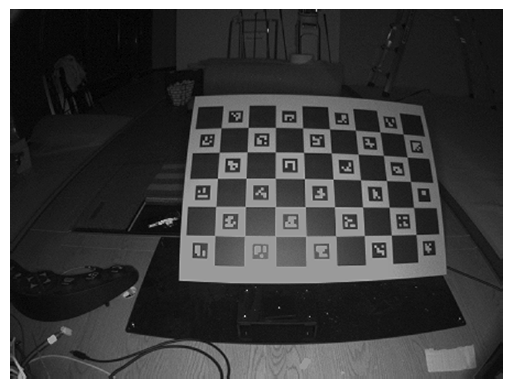

image name,best_grid,best_grid coverage,global coverage,mean pos u,mean pos v,tilt,pan,roll,coverage per grid 1,coverage per grid 2,coverage per grid 3,coverage per grid 4,coverage per grid 5,coverage per grid 6,coverage per grid 7,coverage per grid 8,coverage per grid 9
tv_side_01.bmp,4,0.290426,0.033411,0.472609,0.480596,0.707841,0.918197,0.234254,0.000000,0.000000,0.000000,0.010272,0.290426,0.000000,0.000000,0.000000,0.000000
tv_side_02.bmp,4,0.271573,0.032621,0.458174,0.477851,0.730348,0.890771,-9.363815,0.000000,0.000000,0.000000,0.022020,0.271573,0.000000,0.000000,0.000000,0.000000
tv_side_03.bmp,4,0.300658,0.034693,0.466172,0.483939,0.739375,0.747317,8.961675,0.000000,0.000000,0.000000,0.011579,0.300658,0.000000,0.000000,0.000000,0.000000
tv_side_04.bmp,4,0.274308,0.031491,0.480715,0.413073,0.709239,0.983462,14.316791,0.000000,0.002076,0.000000,0.007038,0.274308,0.000000,0.000000,0.000000,0.000000
tv_side_08.bmp,4,0.501524,0.067610,0.468011,0.410730,0.800133,0.900784,-0.256805,0

In [21]:
# =================================
# Calc evaluation
# =================================
import cv2
from matplotlib import pyplot as plt
import csv
import io

results = []

for (yaml_, img_) in zip(valid_yamls, valid_images):
    pts = load_corners2d_from_yaml(yaml_)

    if pts is not None:

        # 1. Grid coverage
        coverage_per_cell, best_grid_index, best_grid_cov = compute_grid_coverage(pts, (width, height), 3)
        
        # 2. Mean position
        _, _, mean_u, mean_v = compute_mean_uv(pts, (width, height))

        # 3. Global coverage
        global_cov = compute_global_coverage(pts, (width, height))

        # 4. tilt, pan
        tilt_raw, pan_raw = compute_spacing_ratios(pts, rows=5, cols=8)

        # 5) Roll angle
        roll_deg = compute_roll_deg(pts, rows, cols)
        
        #
        # Print values
        #
        print('img: ', os.path.basename(img_))
        print('best_grid', best_grid_index)
        print('best_grid_cov', best_grid_cov)
        print('coverage_per_grid', coverage_per_cell)
        print('mean position U', mean_u)
        print('mean position V', mean_v)
        print('global coverage', global_cov)

        print("Tilt raw ratio:", tilt_raw)
        print("Pan raw ratio:", pan_raw)
        print("Roll (deg):", roll_deg)



        #
        # Show image
        #
        if not os.path.exists(img_):
            raise FileNotFoundError(f'이미지 경로를 찾을 수 없습니다: {img_}')

        src_img = cv2.imread(img_, cv2.IMREAD_COLOR)
        if src_img is None:
            raise ValueError(f'cv2.imread가 이미지로드 실패: {img_}')

        vis = src_img.copy()

        plt.imshow(vis, cmap='gray')
        plt.axis('off')
        plt.show()

        row = {
            "image name": os.path.basename(img_),
            "best_grid": best_grid_index,
            "best_grid coverage": best_grid_cov,
            "global coverage": global_cov,
            "mean pos u": mean_u,
            "mean pos v": mean_v,
            "tilt": tilt_raw,
            "pan" : pan_raw,
            "roll" : roll_deg
        }

        for idx, cov in enumerate(coverage_per_cell):
            row[f"coverage per grid {idx + 1}"] = cov
        results.append(row)

if results:
    headers = [
        "image name",
        "best_grid",
        "best_grid coverage",
        "global coverage",
        "mean pos u",
        "mean pos v",
        "tilt",
        "pan",
        "roll"
    ] + [f"coverage per grid {i}" for i in range(1, 10)]

    csv_buffer = io.StringIO()
    writer = csv.writer(csv_buffer)
    writer.writerow(headers)

    for row in results:
        values = [
            row["image name"],
            str(row["best_grid"]),
            f"{row['best_grid coverage']:.6f}",
            f"{row['global coverage']:.6f}",
            f"{row['mean pos u']:.6f}",
            f"{row['mean pos v']:.6f}",
            f"{row['tilt']:.6f}",
            f"{row['pan']:.6f}",
            f"{row['roll']:.6f}",
        ]
        for i in range(1, 10):
            values.append(f"{row[f'coverage per grid {i}']:.6f}")
        writer.writerow(values)

    csv_text = csv_buffer.getvalue().strip()
    print(csv_text)
else:
    print('No evaluation data collected.')

